# Ventilation Equipment Monitoring

This monitor script is used where CTs are used on circuits activated periodically according to a duty cycle to provide fresh air to the room.<br>

The following issues are used in tickets opened by this script:
- DUTY_CYCLE_BELOW_CRITICAL_VALUE
- DUTY_CYCLE_ABOVE_CRITICAL_VALUE

### DUTY_CYCLE_BELOW_CRITICAL_VALUE<br>
TBD __LOW__ or __NO AIR MOVEMENT__.
### DUTY_CYCLE_ABOVE_CRITICAL_VALUE<br>
TBD __LOW__ or __NO AIR MOVEMENT__.

This script currently uses fixed TCRIT and IDLEBAND settings.  Enhancements may be included at some point to calculate these parameters based on scatter diagram histories.

In [1]:
#Ticket Types
DUTY_CYCLE_BELOW_CRITICAL_VALUE = 10015
DUTY_CYCLE_ABOVE_CRITICAL_VALUE = 10016

#Mote Types producing the Ventilation Equipment CT data
CT_PROFILER_MOTE = 10003
DEPLOYED_ACTIVE  = 10001

In [2]:
import os
import sys
sys.path.append('/home/sensei/jupy-notebooks/Analytics/PorterFarms')
print("============================================")
print("/  Ventilation_CT is running.              /")
print("============================================")
import requests
from datetime import datetime, timedelta
import pytz
from slackclient import SlackClient
import json
import psycopg2 as pg
import pandas.io.sql as psql
import pandas as pd
import configparser
import time

print(os.getcwd())
config = configparser.ConfigParser()
config.read("../../analytics_secrets.ini")

_ACTIVE_STANDBY = config['DEFAULT']['role']
if _ACTIVE_STANDBY == 'STANDBY':
    print("STANDBY")
    raise SystemExit("Stop right there!")
else:
  _SLACK_TOKEN = config['slack']['token']
  _CHIRPSTACK_USER = config['chirpstack']['user']
  _CHIRPSTACK_PASS = config['chirpstack']['password']
  _DB_HOST  = config['kanjidb']['dbhost']
  _DB_PORT  = config['kanjidb']['dbport']
  _DB_NAME  = config['kanjidb']['dbname']
  _DB_USER  = config['kanjidb']['dbuser']
  _DB_PASS  = config['kanjidb']['dbpass']
    
  _LOG_DEBUG = 0
  _LOG_INFO  = 1
  _LOG_ERROR = 2
  _LOG_LEVEL = int(config['DEFAULT']['loglevel'])
      
def logger(level, message):
    if level >= _LOG_LEVEL:
      print(message)

logger(_LOG_DEBUG, "{} {} {} {} {}".format(_DB_HOST, _DB_PORT, _DB_NAME, _DB_USER, _DB_PASS))

import kanjiticketing as kt

conn = kt.getKanjiDbConnection(_DB_HOST, _DB_PORT, _DB_NAME, _DB_USER, _DB_PASS)
if conn is not None:
  print("Welcome to Jupyter Notebook.  You are connected to the Kanji database!")
else:
  print("You are not connected to the database.")

/  Ventilation_CT is running.              /
/home/sensei/jupy-notebooks/Analytics/PorterFarms
Python version
3.7.2 (default, Dec 29 2018, 06:19:36) 
[GCC 7.3.0]
Version info.
sys.version_info(major=3, minor=7, micro=2, releaselevel='final', serial=0)
Welcome to Jupyter Notebook.  You are connected to the Kanji database!


In [3]:
def ticketIssue(conn, node_id, ticket_type):
  openTicket = kt.ticketExists(conn, node_id, ticket_type, [kt._OPEN_STATUS, kt._WORKING_STATUS])
  if openTicket is None:
    query = "SELECT    node.name, node.location_id, location.description, location.slackalertchannel_id, \
                       location.imageurl, customer.slacktoken, slackchannel.idslackchannel, slackchannel.channelid \
                       FROM kanji_node node JOIN kanji_location location ON location.idlocation=node.location_id \
                       JOIN kanji_slackchannel slackchannel ON location.slackalertchannel_id=slackchannel.idslackchannel \
                       JOIN kanji_customer customer ON customer.idcustomer=node.customer_id \
                       WHERE node.idnode={}".format(node_id)
    logger(_LOG_DEBUG, query)
    df = pd.read_sql(query, conn)    
    locationid = df['location_id'][0]
    locationdescription = df['description'][0]
    ticketdescription = "xyz"
    slackchannelid = df['idslackchannel'][0]
    slackchannelname = df['channelid'][0]
    nodename = df['name'][0]
    mentions = "@Charlie"
    locationimageurl = df['imageurl'][0]
    slacktoken = df['slacktoken'][0]
    
    logger(_LOG_DEBUG,"channel={} token={}".format(slackchannelid,slacktoken))
    
    ticketid = kt.openticket(conn, node_id, locationid, ticketdescription, 2, 3, ticket_type, slackchannelid)
    ts = kt.slackticket(nodename, locationdescription, ticketdescription, mentions, 2, 3, locationimageurl, \
                        slacktoken,slackchannelname, ticketid, 0)
    kt.updateTicket(conn, ticketid, ts)  
    logger(_LOG_INFO, "New ticket {} created for this issue.".format(ticketid))
  else:
    logger(_LOG_INFO, "There is an existing ticket {} for this issue. {}".format(openTicket['idticket'][0], openTicket['opentimestamp'][0]))
    

In [4]:
def characterize(df):
  _ICRIT   = 2.0
  tempon   = 0.0
  tempoff  = 0.0
  temponmax    = 0.0
  tempoffmin   = 120.0
  counton  = 0
  countoff = 0
  lastamps = 0.0 
  ampson = 0.0
  ampsoff = 0.0
  for ind in df.index:
    thistemp = df['tempf'][ind]
    thisamps = df['mesh_amps'][ind]   
    if (lastamps<_ICRIT) and (thisamps>=_ICRIT):
      counton += 1
      tempon  += thistemp
      ampson  += thisamps
      if thistemp>temponmax:
        temponmax=thistemp
    elif (lastamps>_ICRIT) and (thisamps<=_ICRIT):
      countoff += 1
      tempoff += thistemp
      ampsoff += thisamps
      if thistemp<tempoffmin:
        tempoffmin=thistemp
    lastamps = thisamps
  if counton>0 and countoff>0:
    dict = {'temponmax': temponmax, 
            'avgon': tempon/counton, 
            'tempoffmin': tempoffmin, 
            'avgoff': tempoff/countoff,
            'avgonamps' : ampson/counton,
            'avgoffamps': ampsoff/countoff,
            #'setpoint': (tempon/counton+tempoff/countoff)/2,
            #'idleband': (tempon/counton-tempoff/countoff)/2,
            'setpoint': (tempoffmin+temponmax)/2,
            'idleband': (temponmax-tempoffmin)/2,
            'counton' : counton,
            'countoff' : countoff}
  else:
    dict = {'temponmax': 80.0, 
            'avgon': 79.0, 
            'tempoffmin': 70.0, 
            'avgoff': 71.0,
            'setpoint': 75.0,
            'idleband': 2.0,
            'avgonamps' : 10.0,
            'avgoffamps': 0.0,
            'counton' : 99,
            'countoff' : 99}
  #logger(_LOG_INFO,"Inferred Thermostat Settings:")  
  #logger(_LOG_INFO, dict)
  return dict

# Strategy
Ventilation fans are cycled on and off during the day to maintain a supply of fresh air to the animals.

### Average Temperature and Fan Current over a Time Interval
The average current within an interval of time is a reflection of the fan's duty-cycle.   The controller should/may be increasing the duty-cycle with rising temperature. Therefore the average temperature is useful in determining if there is an issue with the fan.


Processing Ventilation data for agMote-20010

Ventilation stage 1
Period=30min, T=81.4, A=2.7


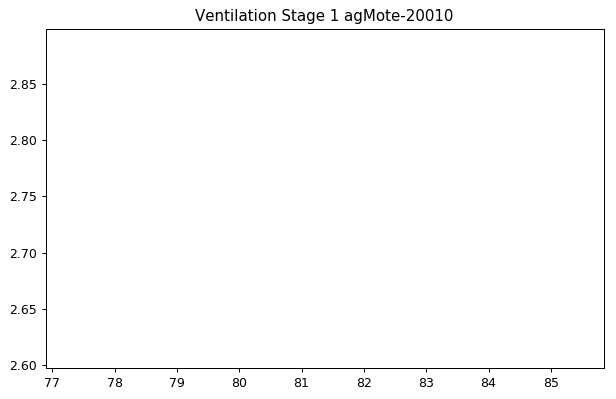


Ventilation stage 2
Period=30min, T=81.4, A=0.5


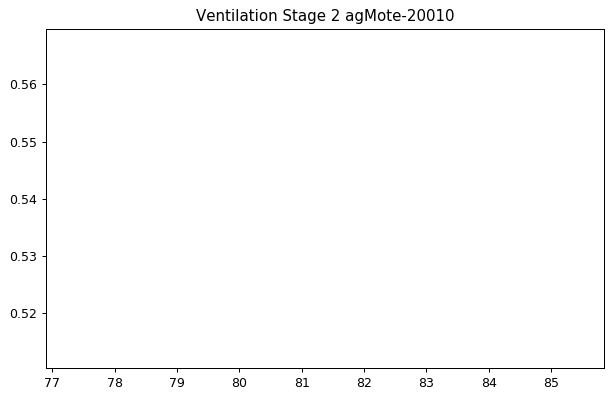

Done!


In [7]:
#_LOG_LEVEL = _LOG_DEBUG
_FIXED = False
_PERIOD_HOURS = 12

from matplotlib import pyplot as plt
from shapely.geometry.polygon import Point, LinearRing
import shapely.geometry as geometry
import shapely.ops as so
from descartes import PolygonPatch

from scipy.optimize import curve_fit

_COLUMNS  = ["fval", "gval"]
_MESHNAMES= ["1", "2"]

#_PERIODS = [5,15,30,60,120,360,720,1440]
_PERIODS = [30]

motequery = "SELECT idnode, name FROM kanji_node WHERE nodetype_id={} AND deploystate_id={}".format(CT_PROFILER_MOTE,DEPLOYED_ACTIVE)
logger(_LOG_DEBUG, "motequery={}".format(motequery))

motes = pd.read_sql(motequery, conn)
if motes.size>0:
 for moteind in motes.index:
  motename = motes['name'][moteind]
  logger(_LOG_INFO,"\nProcessing Ventilation data for {}".format(motename))
  for n in range(0,len(_COLUMNS)):
    logger(_LOG_INFO, "\nVentilation stage {}".format(_MESHNAMES[n])) 
    motename = motes['name'][moteind]
    moteid = motes['idnode'][moteind]
    points = []
    for m in range(0,len(_PERIODS)):
      ctquery = "SELECT avg(bval) AS tempf, \
                        avg({}) AS mesh_amps \
                        FROM kanji_eventlog WHERE node_id={} AND fcnt>0 \
                        AND timestamp>NOW() - INTERVAL '{} MINUTES';".format(_COLUMNS[n], moteid, _PERIODS[m])
      #logger(_LOG_INFO,"event query={}".format(ctquery))
      df = pd.read_sql(ctquery, conn)
      #logger(_LOG_INFO,"  returned {} rows".format(df.size))
      temp = df['tempf'][0]
      amps = df['mesh_amps'][0]
      logger(_LOG_INFO,"Period={}min, T={:.1f}, A={:.1f}".format(_PERIODS[m], temp,amps))
      points.append([temp, amps]) #/_PERIODS[m]])
    
    points = sorted(points)
    fig, ax = plt.subplots(1, figsize=(8,5), dpi=90)
    ax.set_title('Ventilation Stage {} {}'.format(_MESHNAMES[n], motename))
    #xs = [point.x for point in points]
    #ys = [point.y for point in points]
    xs = [point[0] for point in points]
    ys = [point[1] for point in points]
    plt.plot(xs, ys, color='black')
    plt.show()
 
logger(_LOG_INFO, "Done!")      